In [144]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
%run data_loader.py
%run config_loader.py

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:6]  # Select the first 6 experiment names


EVAL REPORT FOR EXPERIMENT:  baseline


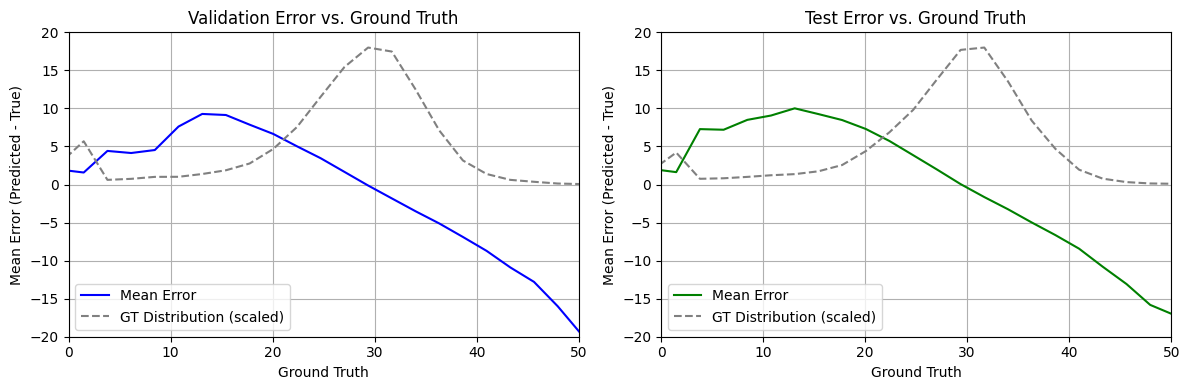

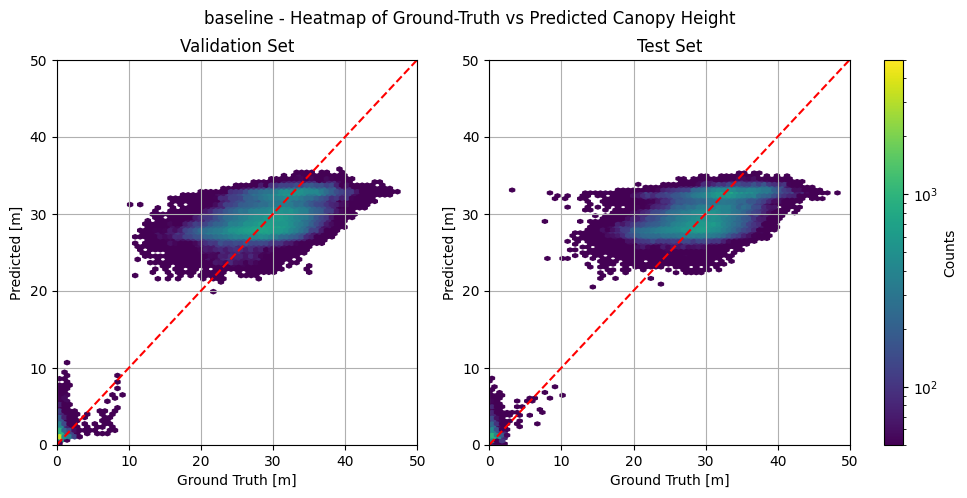

EVAL REPORT FOR EXPERIMENT:  pixel_composites


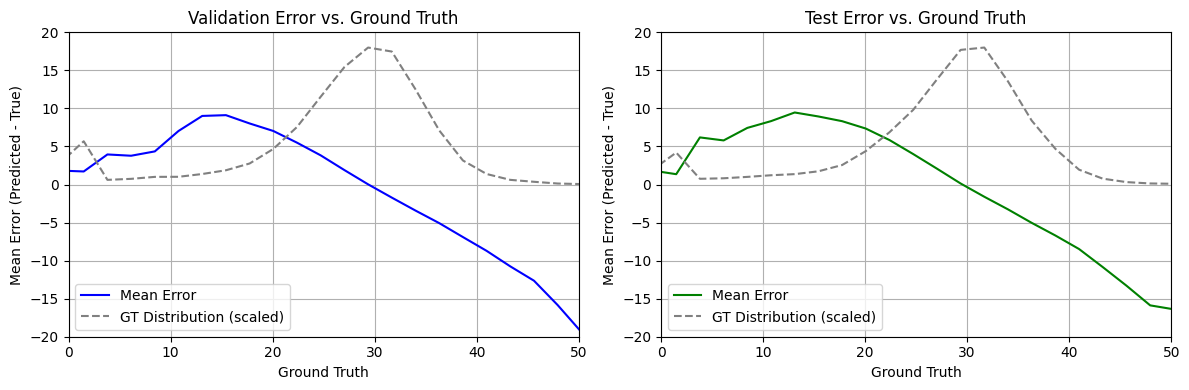

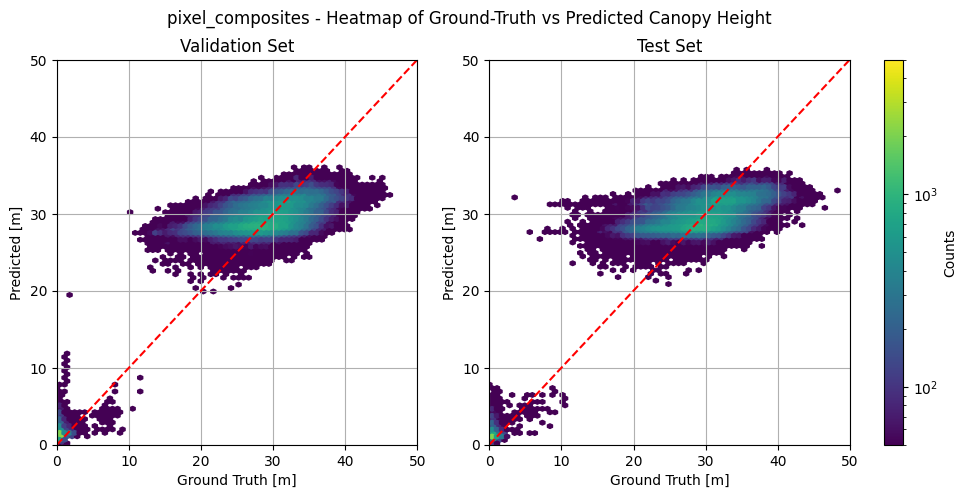

EVAL REPORT FOR EXPERIMENT:  seasonal_composites


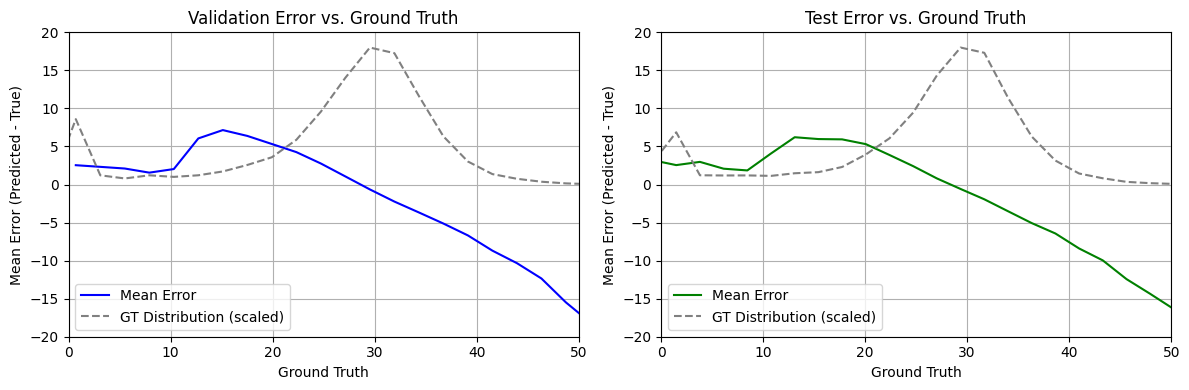

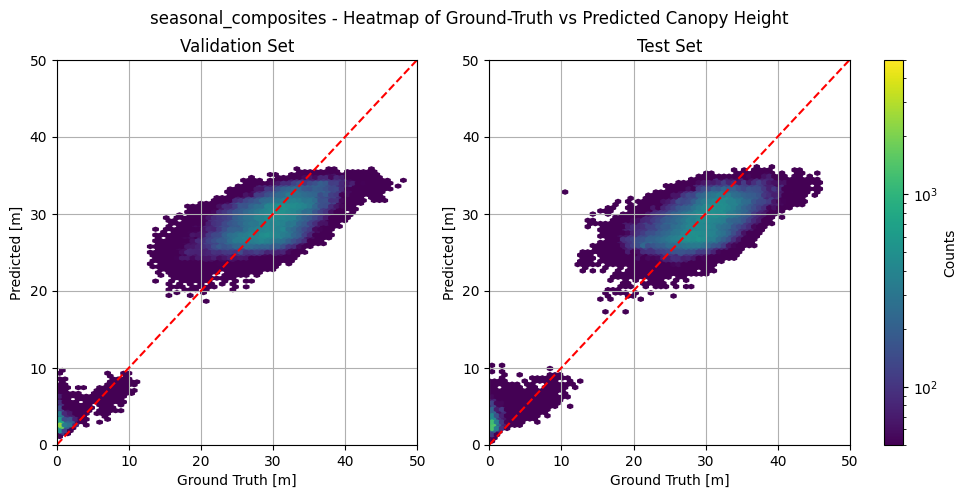

EVAL REPORT FOR EXPERIMENT:  pixel_and_seasonal


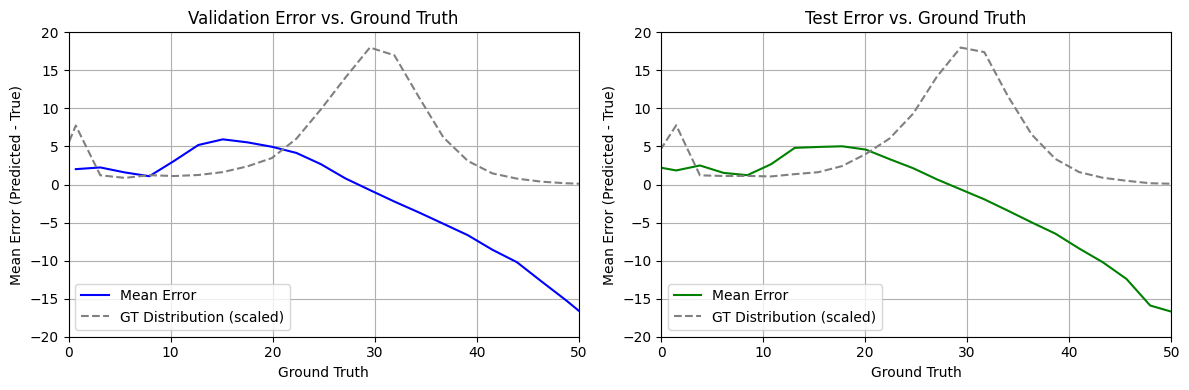

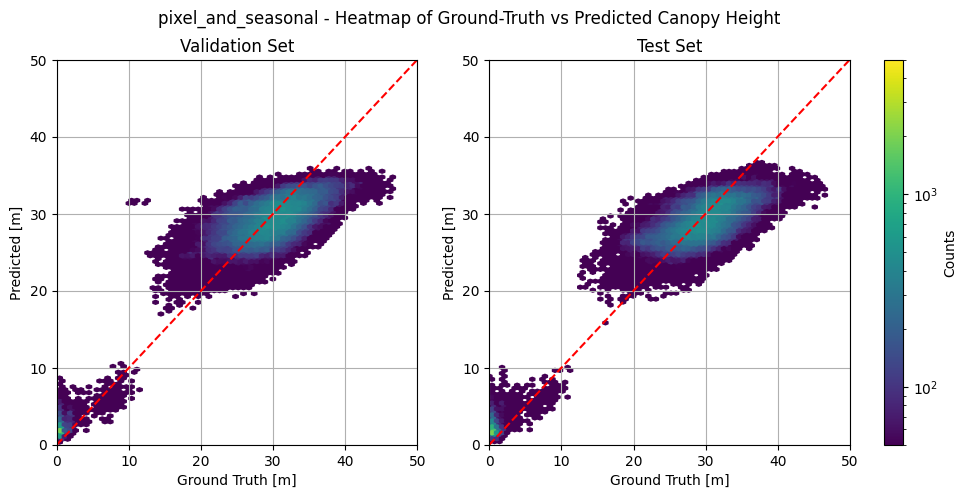

EVAL REPORT FOR EXPERIMENT:  all_aux_data


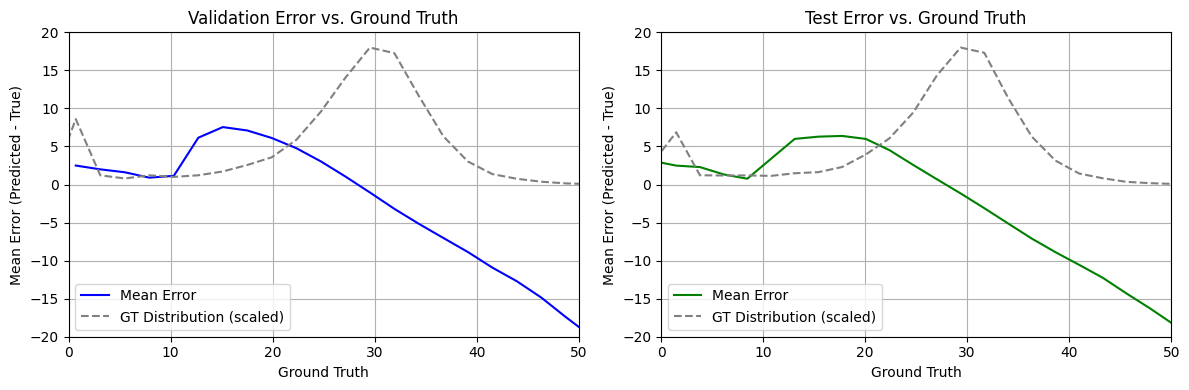

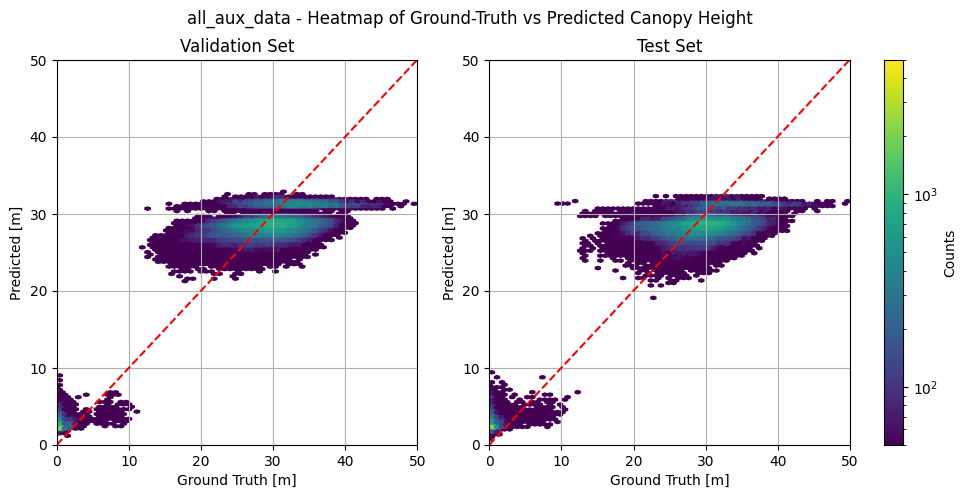

EVAL REPORT FOR EXPERIMENT:  mid_level_learning


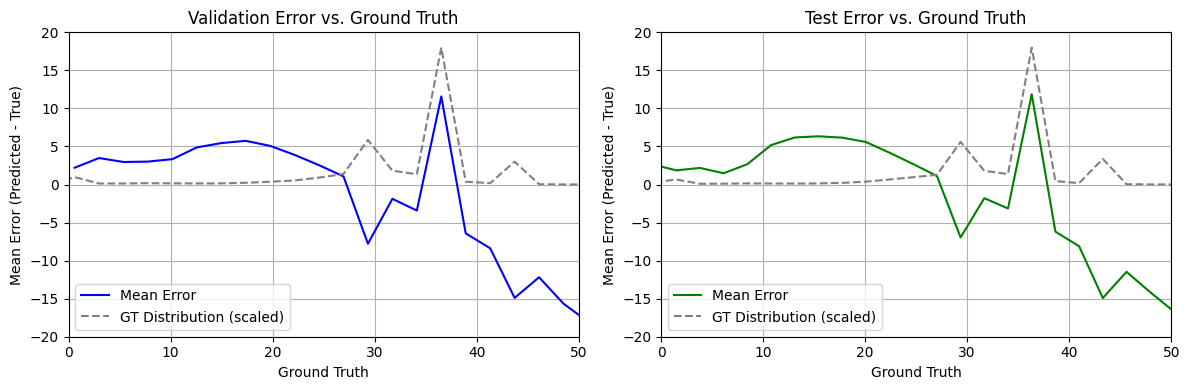

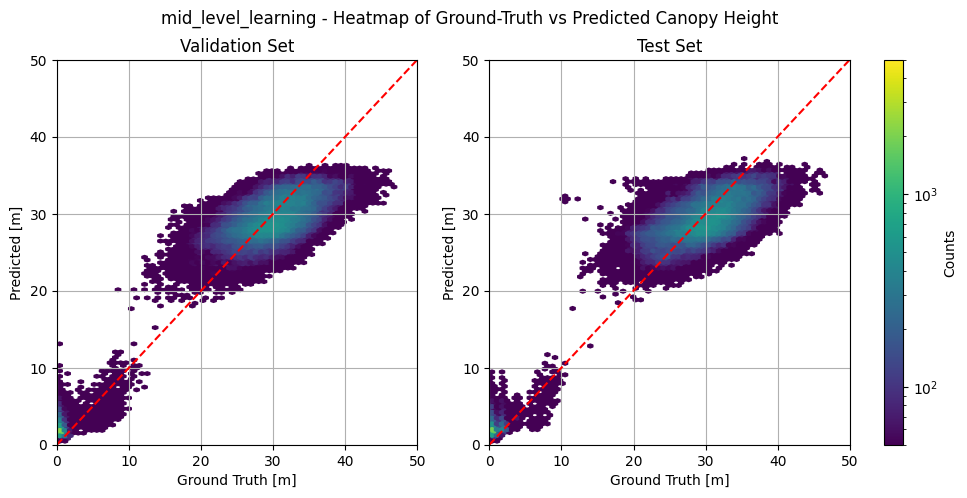

                        0                 1                    2                   3             4                   5
Experiment       baseline  pixel_composites  seasonal_composites  pixel_and_seasonal  all_aux_data  mid_level_learning
MAE [m] (Val)        3.97              3.99                 3.73                3.72          4.23                3.72
MAE [m] (Test)       4.19              4.14                 3.72                3.59          4.23                3.84
RMSE [m] (Val)       5.44              5.47                 5.06                5.16          5.64                5.02
RMSE [m] (Test)      5.72              5.65                 5.06                4.97          5.63                 5.4
Bias [m] (Val)        0.4              0.56                -0.31               -0.52         -0.85               -0.34
Bias [m] (Test)      0.39              0.37                -0.21               -0.51         -0.92               -0.42
R2 [-] (Val)         0.69              0.69     

In [214]:
df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = get_config(exp_name)  
    model_weights, logs, cfg = md.load_results(exp_name)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, cfg, df=df_result)
    print("====================================")

    # print("Experiment name: ", exp_name)
    # print("Sample Count: ", preds_val.shape[0])
    # print("Min/Max pred: ", preds_val.min(), preds_val.max())
    # print("Min/max val: ", targets_val.min(), targets_val.max())

    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    eval.plot_error_over_frequency(targets_val, preds_val, targets_test, preds_test)
    eval.printout_eval_report(report, sites, cfg)
    print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())

In [146]:
preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks('pixel_and_seasonal')

In [158]:
print(f"Shape of preds_val: {preds_val.shape}")
print(f"Shape of targets_val: {targets_val.shape}")
print(f"Shape of preds_test: {preds_test.shape}")
print(f"Shape of targets_test: {targets_test.shape}")
print(f"Shape of maskval: {maskval.shape}")
print(f"Shape of masktest: {masktest.shape}")

Shape of preds_val: (124, 3, 32, 32)
Shape of targets_val: (124, 3, 32, 32)
Shape of preds_test: (125, 3, 32, 32)
Shape of targets_test: (125, 3, 32, 32)
Shape of maskval: (124, 1, 32, 32)
Shape of masktest: (125, 1, 32, 32)


In [133]:
maskval[:,0,:,:] = maskval[:,0,:,:].astype(np.float32)

In [157]:
preds_test[:,0,:,:].min()

np.float32(22.851805)

In [80]:
cfg["strategy"]

'mid_level'

In [45]:
mu = sites['SITE2']['CHM_norm_params']['mu']
std = sites['SITE2']['CHM_norm_params']['std']


In [34]:
report["experiment_name"]

'baseline'

In [31]:
def save_results(model, val_loader, test_loader, normparams, logs, cfg):

    out_dir = os.path.join("../results/train", cfg['exp'])
    os.makedirs(out_dir, exist_ok=True)

    # Save model weights
    torch.save(model.state_dict(), os.path.join(out_dir, "model.pth"))

    # Save logs and cfg as JSON
    with open(os.path.join(out_dir, "logs.json"), "w") as f:
        json.dump(logs, f)
    with open(os.path.join(out_dir, "cfg.json"), "w") as f:
        json.dump(cfg, f)

    # Optionally, save predictions and targets for val/test sets
    preds_val, targets_val = get_predictions_and_targets(val_loader, model, normparams)
    preds_test, targets_test = get_predictions_and_targets(test_loader, model, normparams)

    # Zip predictions and targets for val/test sets and save as .npz files
    np.savez(os.path.join(out_dir, "val_preds_targets.npz"), preds_val=preds_val, targets_val=targets_val)
    np.savez(os.path.join(out_dir, "test_preds_targets.npz"), preds_test=preds_test, targets_test=targets_test)

    print("Results saved to:", out_dir)

def load_np_stacks(exp_dir):
    """
    Loads prediction and target numpy arrays from the experiment results folder.
    Returns preds_val, targets_val, preds_test, targets_test as numpy arrays.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    val_npz = np.load(os.path.join(out_dir, "val_preds_targets.npz"))
    test_npz = np.load(os.path.join(out_dir, "test_preds_targets.npz"))
    preds_val = val_npz["preds_val"]
    targets_val = val_npz["targets_val"]
    preds_test = test_npz["preds_test"]
    targets_test = test_npz["targets_test"]
    return preds_val, targets_val, preds_test, targets_test

def load_results(exp_dir):
    """
    Loads model weights, logs, and cfg from the experiment results folder.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    model_weights = torch.load(os.path.join(out_dir, "model.pth"))
    with open(os.path.join(out_dir, "logs.json"), "r") as f:
        logs = json.load(f)
    with open(os.path.join(out_dir, "cfg.json"), "r") as f:
        cfg = json.load(f)
    return model_weights, logs, cfg

def ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test):
    """
    Compile a new evaluation report for the given experiment.
    """
    report = {
        "experiment_name": exp_name,
        "model_weights": model_weights,
        "logs": logs,
        "config": cfg,
        "predictions": {
            "validation": preds_val,
            "test": preds_test
        },
        "targets": {
            "validation": targets_val,
            "test": targets_test
        }
    }
    return report